# **The Hunt for Exoplanets**
Authors: Lucas Dowers and Brett Kuyper

In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
# sklearn:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score,recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
# imblearn:
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.pipeline import Pipeline as imbpipeline
# pandas
import pandas as pd
# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, MaxPool1D, Flatten, BatchNormalization, Dropout
#light GBM
# from lightgbm import LGBMClassifier
# warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Introduction
What is the best method to train a machine to classify exoplanets with data that contains periodic light readings? This is the question that this notebook hopes to answer. Our dataset can be found on kaggle at: https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?select=exoTest.csv
Below are the technical aspects of our dataset. Notice how unbalanced the set is. There are 5,657 non-exoplanets and only 42 confirmed exoplanets. Because of this imbalance, we will focus more on scores such as balanced-accuracy and f1 score over accuracy throughout this notebook. Let the hunt begin!

##  Data technical specs
    Train set:
      - 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.
      - 5087 rows or observations.
    Test set:
      - 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.
      - 570 rows or observations.
    Combined sets:
      - 42 confirmed exoplanet-stars
      - 5616 non-exoplanet stars
      - 5658 rows
    
    All sets include:
      - 3197 features

    " The samples are taken at regular / precise intervals.
      - In correspondence to 'Earth time' - i.e. time as we understand it -
      - the - total 3000+ intervals span roughly 80 days, all together.
      - The frequency of the samples make use of Barycentric Time "

# Loading The Data
The first step in our plan is to load the data. Below are methods to assist with this. The load_data method is a helper method that returns a feature matrix and an accompanying label vector. This is called by the load_all method, which is used to load our specific data from the "exoTrain.csv", and "exoTest.csv" files. The data_is_valid method can be used to test whether the data was loaded correctly and has not become corrupted in some way. In order to get a more accurate representation of how each classifier is working, the data must be first combined, so that different, random, train/test splits can be made. This is where the combine_X_and_y method comes into play. It puts the train and test data into one matrix/vector pair.

In [3]:
# Helpers
#-------------------------------------------------------------------

def load_data(filename):
    data = np.genfromtxt(filename, skip_header=1, delimiter=',')
    X = np.array(data[:,1:], dtype=np.float64)
    y = np.array(data[:, 0])
    y[y == 1] = 0 # is no confirmed exo's.
    y[y == 2] = 1 # is a confirmed exo.
    return X, y

def load_all(standard=False,smote=False):
    X_train, y_train = load_data('exoTrain.csv')
    X_test, y_test = load_data('exoTest.csv')
    if(smote):
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    if(standard):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test

def data_is_valid(X, y, examples=0, features=0):
    return (
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==0) | (y==1))
    )


# combines our test and train data.
def combine_X_and_y(X_train, y_train, X_test, y_test):
  combined_X = np.vstack((X_train, X_test))
  combined_y = np.concatenate((y_train, y_test))
  return combined_X, combined_y

Time to make use of these methods and load the data.

In [4]:
# Loading data:
#-------------------------------------------------------------------
exo_train_X, exo_train_y, exo_test_X, exo_test_y  = load_all()
print("validity for exo train: ", data_is_valid(exo_train_X, exo_train_y, examples=5087, features=3197))
print("validity for exo test: ", data_is_valid(exo_test_X, exo_test_y, examples=570, features=3197))

# Loading data: Combined all Data
combined_X, combined_y = combine_X_and_y(exo_train_X, exo_train_y, exo_test_X, exo_test_y)
#-------------------------------------------------------------------


validity for exo train:  True
validity for exo test:  True


# Analyzing the Data
Below are the methods used in this notebook for analyzing how useful each classifier is for the purpose of classifying exoplanets. get_classifier and get_pipeline are both helper methods that are used by the findBestEstimator and stratAnalyze functions. get_classifier returns a classifier based off of a string parameter. The get_pipeline method returns a pipeline that possesses different pre-processing steps depending on the parameters given to it. It also includes the classifier that was made from the get_classifier method. The findBestEstimator method runs grid search on a classifier in order to determine what the best hyperparameters are for that particular classifier. The stratAnalyze method performs cross validation on a classifier using StratifiedKFold and an optional parameter for doing grid search as well. We seperated the stratAnalyze and the findBestEstimator methods because of the computing power that running a grid search into a cross validation takes on a big dataset such as the exoplanets dataset.

In [5]:
def get_classifier(classifier):
    if(classifier=="nn"):
        return KNeighborsClassifier()
    elif(classifier=="SVM"):
        return LinearSVC(class_weight='balanced', max_iter=2500, random_state=13) # also in include dual="auto" in jupyter notebook.
    elif(classifier=="forest"):
        return BalancedRandomForestClassifier(replacement=True, random_state=13)
    elif(classifier=="easy"):
        return EasyEnsembleClassifier(random_state=13)
    elif(classifier=="rbf"):
        return SVC(kernel='rbf', random_state=13)
    else:
        print("classifier not supported")
        return

# can add more options as we like.
def get_pipeline(classifier,process,pca_n_component):
    if process == 'standard':
        pipeline = Pipeline([('standardize', StandardScaler()),
                            ('pca', PCA(n_components=pca_n_component)),
                            ('classifier', classifier)])
        return pipeline
    elif process == 'normalize':
        pipeline = Pipeline([('normalizer', Normalizer()),
                            ('pca', PCA(n_components=pca_n_component)),
                            ('classifier', classifier)])
        return pipeline
    elif process == 'smote':
        pipeline = imbpipeline(steps =[['smote', SMOTE(sampling_strategy='minority', random_state=7)],
                                       ['scaler', StandardScaler()],['pca', PCA(n_components=pca_n_component)],
                                       ['classifier', classifier]])
        return pipeline
    elif process == 'under':
        pipeline = imbpipeline(steps =[['smote', RandomUnderSampler(random_state=13)],
                                       ['scaler', StandardScaler()],
                                       ['classifier', classifier]])
        return pipeline
    elif process == 'under_pca':
        pipeline = imbpipeline(steps =[['under', RandomUnderSampler(random_state=13)],
                                       ['scaler', StandardScaler()], ['pca', PCA(n_components=pca_n_component)],
                                       ['classifier', classifier]])
        return pipeline
    elif process == 'none':
        return Pipeline([('classifier',classifier)])

def FindBestEstimator(X,y,processor='none',classifier="nn",pca_n_component=50,param_grid=[]):
    Classifier = get_classifier(classifier)
    pipeline = get_pipeline(Classifier, processor,pca_n_component)
    classifier_grid = GridSearchCV(pipeline,param_grid=param_grid,scoring="balanced_accuracy")
    classifier_grid.fit(X, y)
    return classifier_grid.best_estimator_

# added a pipeline to this and get_pipeline chooses what we want to
# add to pipeline
def stratAnalyze(X,y,processor ='none',classifier="nn",splits=5,pca_n_component=50,
                 grid=False,param_grid=[], fitTwice=False):
    if(grid == True):
        Classifier = get_classifier(classifier)
        pipeline = get_pipeline(Classifier, processor,pca_n_component)
        cv = StratifiedKFold(n_splits=splits, random_state=1, shuffle=True)
        classifier_grid = GridSearchCV(pipeline,param_grid=param_grid,scoring="balanced_accuracy")
        if(fitTwice):
          classifier_grid.fit(X, y) # commenting this out for now so doesn't take so long.
        accuracy = cross_validate(classifier_grid,X,y, cv=cv,
                           scoring=scoring)
        if(fitTwice):
          return accuracy, classifier_grid.best_estimator_
        return accuracy

    pipeline = get_pipeline(classifier, processor,pca_n_component)
    cv = StratifiedKFold(n_splits=splits, random_state=1, shuffle=True)
    accuracy = cross_validate(pipeline,X,y, cv=cv,
                           scoring=scoring)
    return accuracy

## Scoring
Scoring metrics are an important concept to consider when comparing classifiers. As stated earlier, our data is heavily unbalanced in favor of non-exoplanets. Because of this we have included scores other than accuracy. Accuracy will be a heavily skewed scoring metric, because a classifier that does not guess a single exoplanet correctly can still have a high accuracy score due to the imbalances in the dataset. The goal of this notebook is to create a machine that can find exoplanets, so we have included balanced accuracy, roc_auc, precision, recall, f1 score, true positive/negative, and false positive/negative. A confusion matrix is a very good way to see how our classifiers are performing. Having these metrics on our dataframes is very helpful in determining the performance. Accuracy is included to show how unreliable it can be, however it is still good to show because our goal is to achieve a high accuracy as well as a high balanced accuracy. For example, if we notice our balanced accuracy score increasing, but our accuracy decreases quite a bit, this is a sign that we might have some major overfitting / underfitting in our model. So even though accuracy can be unreliable, it is still helpful to keep an eye on.

In [6]:
# Scoring Metrics

def true_n(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn
def false_p(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp
def false_n(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn
def true_p(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro'),
    'true_positive': make_scorer(true_p),
    'false_positive': make_scorer(false_p),
    'true_negative': make_scorer(true_n),
    'false_negative': make_scorer(false_n),
}

def neural_scoring_metrics(X,y,model,accuracy_list):
    y_class_pred = (model.predict(X) > 0.5).astype("int32")

    accuracy_list.append(accuracy_score(y, y_class_pred))
    accuracy_list.append(balanced_accuracy_score(y, y_class_pred))
    accuracy_list.append(roc_auc_score(y, y_class_pred))
    accuracy_list.append(precision_score(y, y_class_pred,average='macro'))
    accuracy_list.append(recall_score(y, y_class_pred,average='macro'))
    accuracy_list.append(f1_score(y, y_class_pred,average='macro'))
    accuracy_list.append(true_p(y, y_class_pred))
    accuracy_list.append(false_p(y, y_class_pred))
    accuracy_list.append(true_n(y, y_class_pred))
    accuracy_list.append(false_n(y, y_class_pred))

    return accuracy_list

# Visualizing Data

---


In order to visualize the above scoring metrics, here is a function for creating a dataframe. This will be used in interpreting the results of experiments run in this notebook.

In [7]:
# Final DataFrame of our results.
def make_dataframe_line(accuracy_list, name):
    return [name, np.mean(accuracy_list['test_accuracy']), np.mean(accuracy_list['test_balanced_accuracy']),
            np.mean(accuracy_list['test_roc_auc']),np.mean(accuracy_list['test_precision']),np.mean(accuracy_list['test_recall']),
            np.mean(accuracy_list['test_f1_score']), np.mean(accuracy_list['test_true_positive']), np.mean(accuracy_list['test_false_positive']),
            np.mean(accuracy_list['test_true_negative']), np.mean(accuracy_list['test_false_negative'])]

def make_dataframe_neural(accuracy_list):
    return [accuracy_list[0], accuracy_list[1],
            accuracy_list[2],accuracy_list[3],accuracy_list[4],
            accuracy_list[5], accuracy_list[6], accuracy_list[7],
            accuracy_list[8], accuracy_list[9]]

def make_dataframe_neural_mean(accuracy_list,name):
       return [name, np.mean(accuracy_list[::10]),np.mean(accuracy_list[1::10]),
               np.mean(accuracy_list[2::10]),np.mean(accuracy_list[3::10]),
               np.mean(accuracy_list[4::10]),np.mean(accuracy_list[5::10]),
               np.mean(accuracy_list[6::10]),np.mean(accuracy_list[7::10]),
               np.mean(accuracy_list[8::10]),np.mean(accuracy_list[9::10])]

# Plot Templates

Templates below include visualizing the light fluxes over time, distribution of the labels, and a final plot we will use to show balanced accuracy scores for all classifiers.

In [8]:
# Plot Templates
def flux_intro_plots(a, X, star_list, facecolor,title,y_label,x_label, color):
    flux_of_star = X[star_list[i]]
    time = np.arange(len(flux_of_star)) * (39/60.0)
    a.set_facecolor(facecolor)
    a.set_title(title.format(star_list_confirmed[i]+1), fontweight='bold', fontsize=12)
    a.set_ylabel(y_label, fontweight='bold')
    a.set_xlabel(x_label, fontweight='bold')
    a.plot(time, flux_of_star, color=color)

def scatter_plot_of_features(X,y,title):
  features = np.arange(X.shape[1])
  colors = {0: 'grey', 1: 'red'}
  labels = ['Star With No Exoplanet', 'Star With Exoplanet']

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
  # Plotting the mean value of each feature for each label
  for label in np.unique(y):
    mean_values = np.mean(X[y == label], axis=0)
    # label=f'Label {label}'
    ax1.scatter(features , mean_values, label=labels[label.astype(int)] , color=colors[label], alpha=0.5)

  ax1.set_yscale('log')
  ax1.set_xlabel('Features')
  ax1.set_ylabel('Mean Value')
  ax1.set_title('Mean Values Of Exoplanet Labels And Non Exoplanet Labels')
  ax1.legend()
  # plt.show()

  for i, label in enumerate(y):
    if label == 0:
      if i == 6:
        ax2.semilogx(features, X[i], color=colors[label], alpha=0.5, label='Star With No Exoplanet')
      else:
        ax2.semilogx(features, X[i], color=colors[label], alpha=0.2)
    else:
      if i == 0:
        ax2.semilogx(features, X[i], color=colors[label], alpha=0.9, label='Star With Exoplanet')
      else:
        ax2.semilogx(features, X[i], color=colors[label], alpha=0.9)

  ax2.set_xlabel('Features (Light fluxes Over Time)')
  ax2.set_ylabel('Values')
  ax2.set_title('Light Fluxes For Stars With And Without Exoplanet')
  ax2.set_yscale('log')
  ax2.legend()

  plt.suptitle(title, fontweight='bold')
  plt.subplots_adjust(hspace=0.3)
  plt.show()

def final_balanced_plots(acc_all, acc_mean):
  classifiers = ['Linear SVM', 'Non-Linear RBF', 'Easy Ensemble', 'Balanced Forest', 'KNN', 'RNN-LSTM', 'CNN']
  index=[0,1,2,3,4,5,6,7,8,9]

  fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20, 10))
  fig.set_facecolor('#DEE4F3')
  for i, a in enumerate(acc_all):
    ax1.scatter(index, a, label=classifiers[i], marker='o')
    ax1.plot(index, a, linestyle='-')

  for i, a in enumerate(acc_mean):
    ax2.bar(classifiers[i], a, label=classifiers[i])

  ax1.set_title('Balanced Accuracies of Classifiers Over 10 Splits', fontweight='bold', fontsize='20')
  ax1.set_ylabel('Accuracy', fontweight='bold', fontsize='12')
  ax1.legend(loc='best')

  ax2.set_title('Mean Balanced Accuracies of Classifiers Over 10 Splits', fontweight='bold', fontsize='20')
  ax2.set_ylabel('Accuracy', fontweight='bold', fontsize='12')
  ax2.set_xlabel('Classifiers', fontweight='bold', fontsize='12')
  ax2.set_ylim(0.5, 0.85)
  plt.show()


# Visualizing flux variations of stars over time.

The following graphs are to get more familiar with our data. We randomly picked 3 stars with a confirmed exoplanet and 3 stars with no exoplanets.

---
The first 3 graphs are stars with a confirmed exoplanet.

---
The final 3 graphs are stars with no confirmed exoplanets.

---
In order to get a full picture of the data and the  distrubution, we will take a look at both labels on the same plot. This will be described below in further detail.



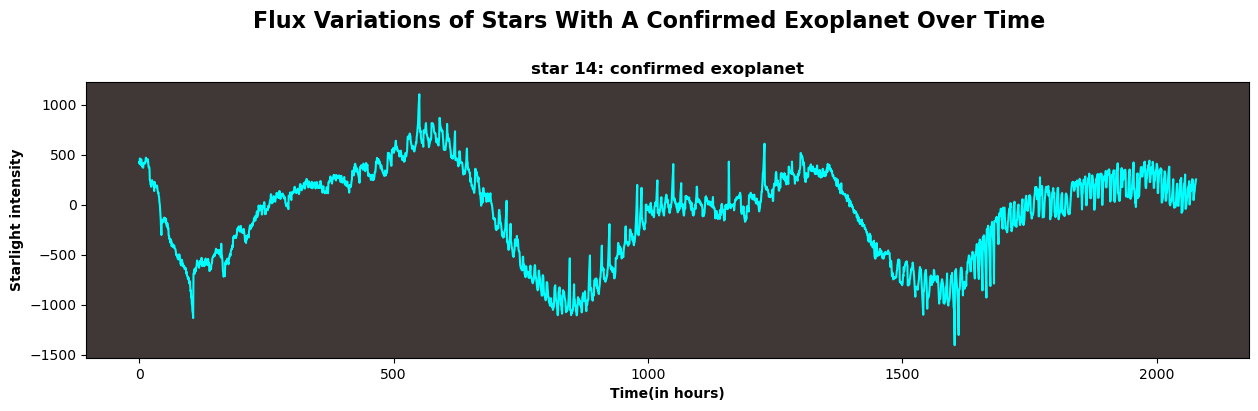

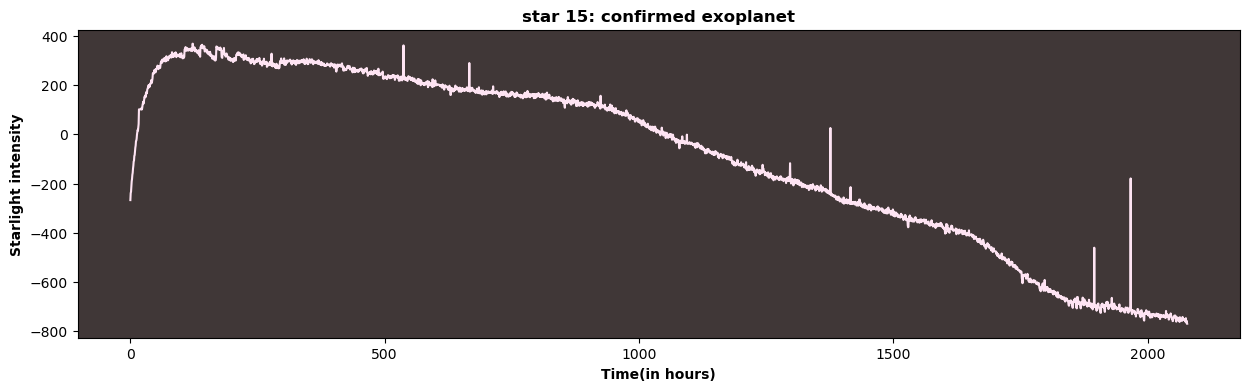

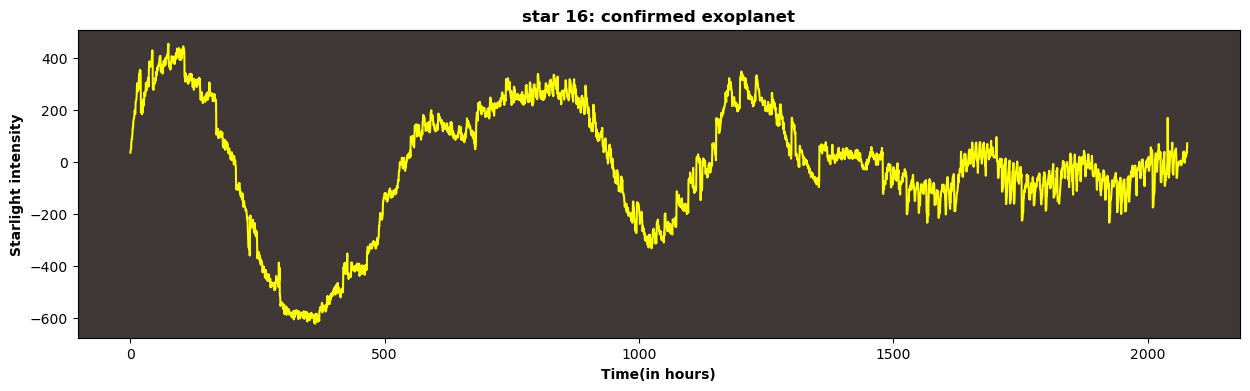

In [9]:
# Confirmed / standardization flux comparisons
star_list_confirmed = [13,14,15]
colors = ['cyan', '#FEE4F3', 'yellow']
for i in range(3):
    fig, (ax1) = plt.subplots(1,1, figsize=(15, 4))
    flux_intro_plots(ax1, exo_train_X, star_list_confirmed,'#403737','star {}: confirmed exoplanet','Starlight intensity','Time(in hours)', colors[i])
    if i == 0:
      plt.subplots_adjust(top=0.80)
      fig.suptitle('Flux Variations of Stars With A Confirmed Exoplanet Over Time', fontsize=16, fontweight='bold')

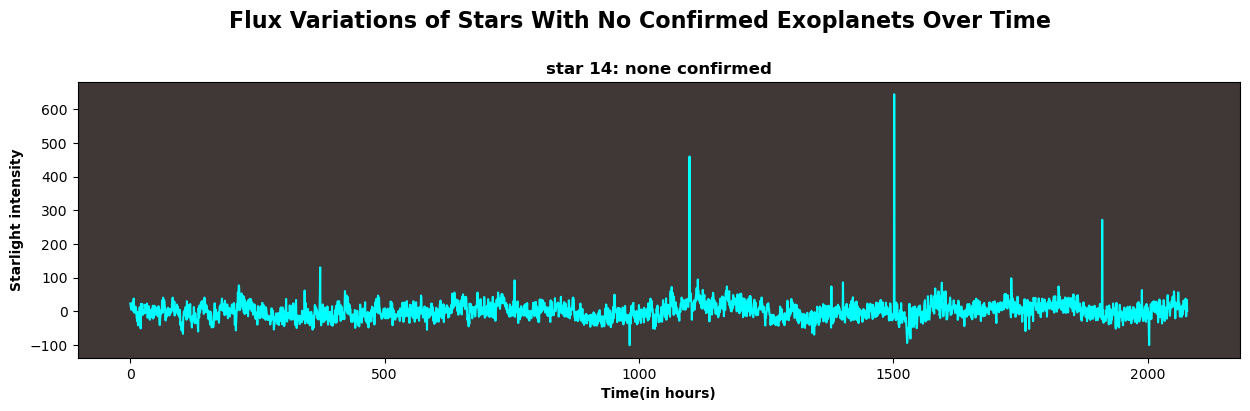

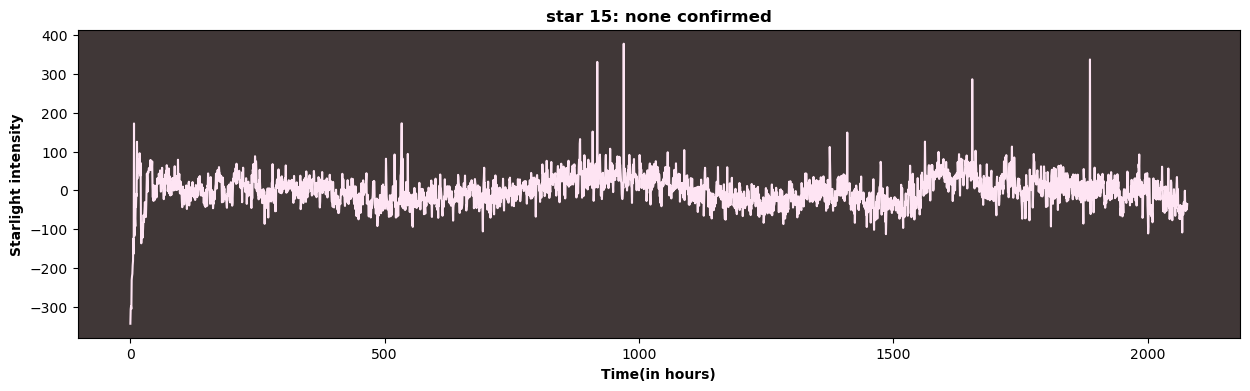

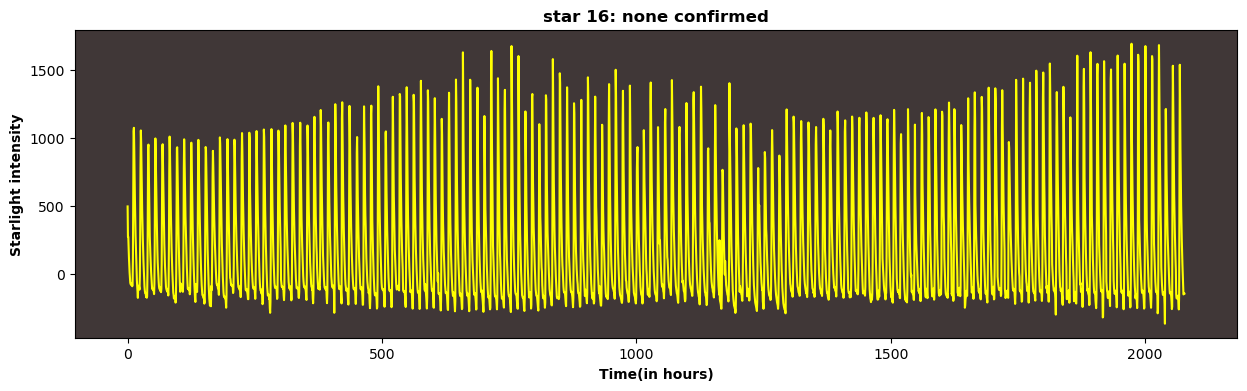

In [10]:
# none Confirmed / standardization flux comparisons
star_list_none_confirmed = [2006,3009,4176]
colors = ['cyan', '#FEE4F3', 'yellow']
for i in range(3):
    fig, (ax1) = plt.subplots(1,1, figsize=(15, 4))
    flux_intro_plots(ax1, exo_train_X, star_list_none_confirmed,'#403737','star {}: none confirmed','Starlight intensity','Time(in hours)', colors[i])
    if i == 0:
      plt.subplots_adjust(top=0.80)
      fig.suptitle('Flux Variations of Stars With No Confirmed Exoplanets Over Time', fontsize=16, fontweight='bold')

# Visualizing confirmed exoplanets and no confirmed exoplanets on the same plot.

With the above plots seperated and showing only one example, it appears to be somewhat easy to decide whether or not a star has an exoplanet. However, the entire dataset begins to tell a different story and further shows the difficulty of our dataset.

---
The 4 plots that follow will show the distrubtion of labels and the light fluxes over entire dataset. The grey color will represent a star with no exoplanet, and the red color will represent a star with a confirmed exoplanet.

---
The first plot generates a scatter plot based on the mean value of each binary label at each step in time. A unique persepective, but we were curious what this might show.

The second plot shows the light fluxes over the entire dataset for both confirmed and no confirmed exoplanets.

We thought our dataset might be difficult to classify based on the imbalance and the first two plots visually confirm this.

---
Plots three and four are generated in the same way, but we apply PCA to our data. Because of the size of our data, testing different hyperparamters was becoming time-consuming and expensive. One thing we explored was using PCA. For many of our classifiers, we noticed a slight boost in accuracy as a result of using PCA and wanted to visually see the effect of PCA over the entire data. For these last two plots, we applied an n_component of 50 to our PCA. This n_component of 50 also seems to be on average, the optimal number to use for our classifiers.

Plot three takes the mean value of the binary labels for each feature through time and generates a scatter plot. The second plot shows the entire dataset for both confirmed and no-confirmed. Both using PCA(n_component=50)

---
The plots that have PCA applied, show that this decomposition tool might aid in our classification if used properly.

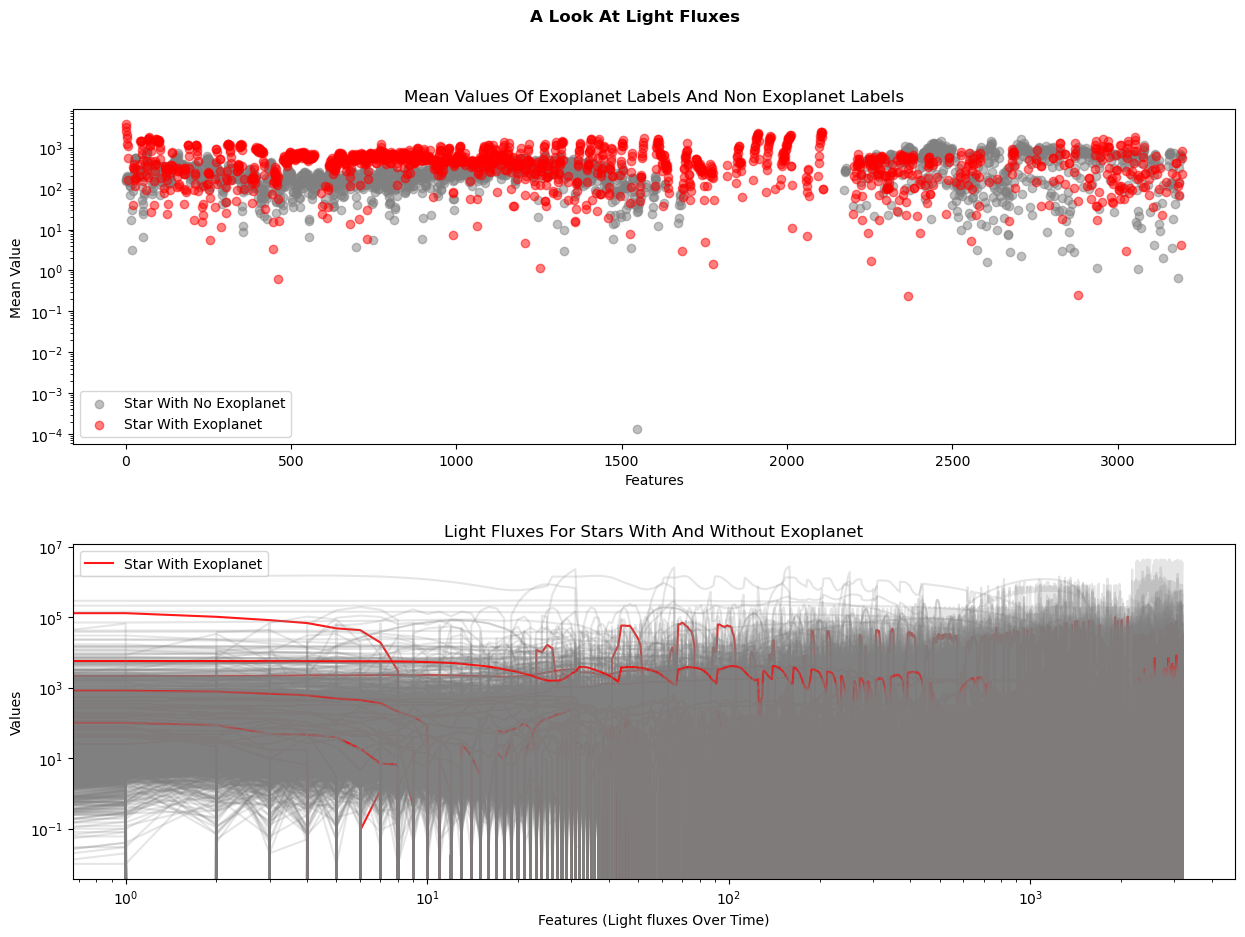

In [11]:
scatter_plot_of_features(combined_X, combined_y,'A Look At Light Fluxes')

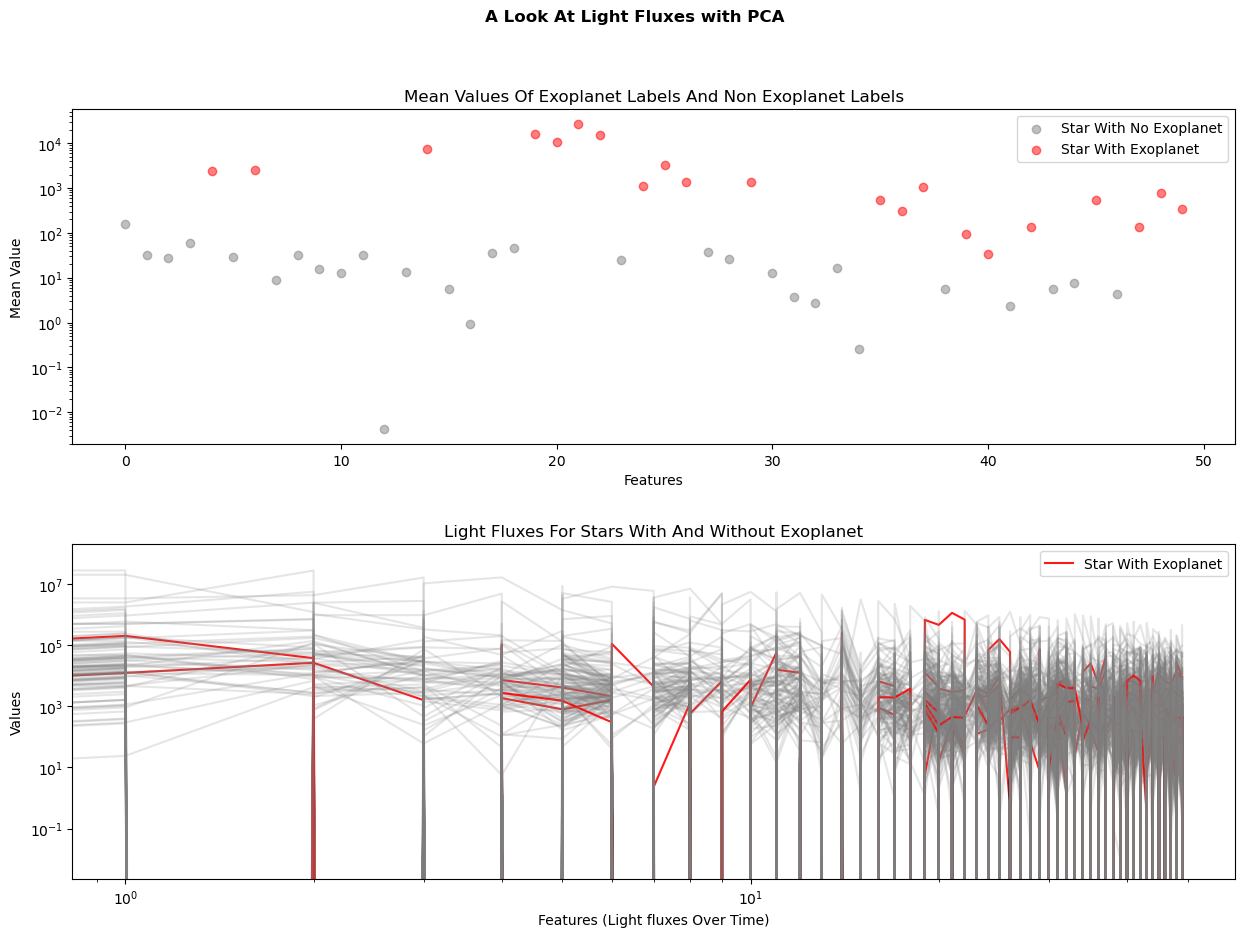

In [12]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(combined_X)
scatter_plot_of_features(X_pca, combined_y,'A Look At Light Fluxes with PCA')

# Classification

We begin our search for the best classifier using a baseline. For our project, we are using a LinearSVC as our baseline and this is what we hope to improve on.

---
Because of the difficulties from our dataset, we are not only trying to tune our hyperparameters, but are also searching for an optimal classifier.

In all cases, we have considered whether or not to standardize our data, normalize our data, use PCA, under-sample our majority class or over-sample our minority class. We have attempted many of these combinations to narrow down our choices and the classifiers that are shown are the best options we have currently found.

Our results for each classifier will show what is contained in our pipeline, the best estimator found over 5 folds, and the scoring metrics over 5 folds.


### **Our Classifiers will be ran in the order below**.

---
LinearSVC - Baseline

---
Non-Linear SVC

---
Easy Ensemble

---
Balanced Random Forest

---
KNN

---
Recurrent Neural Network-Long Short Term Memory

---
Convolutional Neural Network

---

# Linear SVC
The linear SVC is a good baseline for our experimentation given that our data is not seperable by a 2-dimensional line (seen in the plots above). Because of this, the linear SVC should not be the best performing classifier. In order to get the best accuracy for this classifier, we have standardized the data, and performed a grid search on it to find an optimal parameter C. This classifier was very time consuming with our dataset so we chose to use random under sampling. After under sampling, PCA was no longer beneficial with this classifier.

In [13]:
#Test SVM Linear gridsearch
param_grid = [
  {'classifier__C': [.0001,.001,.01,1,10,20]}
 ]
accuracy_svm,best_estimator = stratAnalyze(combined_X,combined_y,"under",classifier="SVM",splits=10,grid=True,param_grid=param_grid,fitTwice=True)
print("Best Estimator:",best_estimator)
accuracy_svm_df = pd.DataFrame(accuracy_svm)
accuracy_svm_df.iloc[:, 2:]

Best Estimator: Pipeline(steps=[('smote', RandomUnderSampler(random_state=13)),
                ('scaler', StandardScaler()),
                ['classifier',
                 LinearSVC(C=1, class_weight='balanced', max_iter=2500,
                           random_state=13)]])


,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1_score,test_true_positive,test_false_positive,test_true_negative,test_false_negative
0,0.833922,0.718004,0.718004,0.513666,0.718004,0.484457,3,92,469,2
1,0.856890,0.927807,0.927807,0.529070,0.927807,0.516040,5,81,480,0
2,0.869258,0.437722,0.437722,0.495968,0.437722,0.465028,0,70,492,4
3,0.830389,0.542260,0.542260,0.502141,0.542260,0.463782,1,93,469,3
4,0.851590,0.677046,0.677046,0.509830,0.677046,0.482497,2,82,480,2
5,0.878092,0.690391,0.690391,0.512481,0.690391,0.494819,2,67,495,2
6,0.821555,0.413701,0.413701,0.495736,0.413701,0.451018,0,97,465,4
7,0.826549,0.416221,0.416221,0.495754,0.416221,0.452519,0,94,467,4
8,0.856637,0.927807,0.927807,0.523529,0.927807,0.506039,4,81,480,0
9,0.854867,0.554590,0.554590,0.503157,0.554590,0.472708,1,79,482,3


# Non-linear SVC
One way to improve upon a linear SVC is to make it non-linear. In this notebook that is done through kernels. Along with the earlier tested C parameter, the grid for this classifier now also includes gamma, and two different types of kernel. The gamma parameter will aid with overfitting that can occur from the C parameter. We experimented with both rbf and poly kernels previous. The poly kernel alone tended to give better results. Due to long testing times we have added undersampling to the non-exoplanets for this classifier. This is done through the pipeline. After under sampling, PCA was no longer beneficial with this classifier.

In [14]:
#Test SVM 'rbf' , 'poly' gridsearch
param_grid = [
  {'classifier__C': [.0001,.001,.01,.1,1,10,20],
   'classifier__gamma': [1,10,20],
   'classifier__class_weight':['balanced'],
   'classifier__kernel': ['poly']
   }
 ]
accuracy_rbf,best_estimator = stratAnalyze(combined_X,combined_y,"under",classifier="rbf",splits=10,grid=True,param_grid=param_grid, fitTwice=True)
print("Best Estimator:",best_estimator)
accuracy_rbf_df = pd.DataFrame(accuracy_rbf)
accuracy_rbf_df.iloc[:, 2:]

Best Estimator: Pipeline(steps=[('smote', RandomUnderSampler(random_state=13)),
                ('scaler', StandardScaler()),
                ['classifier',
                 SVC(C=0.0001, class_weight='balanced', gamma=10, kernel='poly',
                     random_state=13)]])


,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1_score,test_true_positive,test_false_positive,test_true_negative,test_false_negative
0,0.828622,0.715330,0.715330,0.513169,0.715330,0.481993,3,95,466,2
1,0.865724,0.734046,0.734046,0.517436,0.734046,0.500395,3,74,487,2
2,0.925795,0.466192,0.466192,0.496212,0.466192,0.480734,0,38,524,4
3,0.839223,0.422598,0.422598,0.495825,0.422598,0.456292,0,87,475,4
4,0.872792,0.687722,0.687722,0.511865,0.687722,0.492225,2,70,492,2
5,0.846290,0.674377,0.674377,0.509407,0.674377,0.480191,2,85,477,2
6,0.819788,0.536922,0.536922,0.501781,0.536922,0.460004,1,99,463,3
7,0.838938,0.546569,0.546569,0.502467,0.546569,0.466876,1,88,473,3
8,0.860177,0.929590,0.929590,0.524096,0.929590,0.508105,4,79,482,0
9,0.851327,0.676916,0.676916,0.509826,0.676916,0.482420,2,82,479,2


# Easy Ensemble

This classifier will take advantage of random undersampling and PCA. The parameters of Easy Ensemble that we will be testing are **n_estimators** and **estimator**. n_estimators is the number of AdaBoost learners in the model. The 'estimator' parameter is the base classifier used in the inner ensemble.   BalancedRandomForestClassifier and AdaBoostClassifier will be tested for this inner ensembl. The default parameter for replacement was 'false', but we chose to sample randomly with replacement.

---
We also use random under-sampling to resample our majority class. Easy Ensemble integrates its own sampling strategy as well that will further attempt to balance our data.

In [15]:
#Test gridsearch easy E
param_grid_e = {'classifier__n_estimators': [5,10],
              'classifier__estimator': [BalancedRandomForestClassifier(class_weight='balanced', random_state=7), AdaBoostClassifier(random_state=7)],
              'classifier__replacement': [True],
               }

accuracy_easy_e, best_estimator = stratAnalyze(combined_X,combined_y,"under_pca",classifier="easy",splits=10,pca_n_component=50, grid=True,param_grid=param_grid_e,fitTwice=True)
print("Best Estimator:",best_estimator)
accuracy_easy_e_df = pd.DataFrame(accuracy_easy_e)
accuracy_easy_e_df.iloc[:, 2:]

Best Estimator: Pipeline(steps=[('under', RandomUnderSampler(random_state=13)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ['classifier',
                 EasyEnsembleClassifier(estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                                                 random_state=7),
                                        random_state=13, replacement=True)]])


,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1_score,test_true_positive,test_false_positive,test_true_negative,test_false_negative
0,0.697880,0.649376,0.649376,0.506183,0.649376,0.427420,3,169,392,2
1,0.712014,0.854724,0.854724,0.514881,0.854724,0.443917,5,163,398,0
2,0.743816,0.622776,0.622776,0.504521,0.622776,0.439669,2,143,419,2
3,0.696113,0.722865,0.722865,0.507345,0.722865,0.426707,3,171,391,1
4,0.848057,0.675267,0.675267,0.509545,0.675267,0.480955,2,84,478,2
5,0.683746,0.840747,0.840747,0.510929,0.840747,0.426681,4,179,383,0
6,0.736749,0.743327,0.743327,0.508729,0.743327,0.443101,3,148,414,1
7,0.805310,0.777852,0.777852,0.512289,0.777852,0.471621,3,109,452,1
8,0.755752,0.877005,0.877005,0.514085,0.877005,0.457275,4,138,423,0
9,0.690265,0.347594,0.347594,0.494924,0.347594,0.408377,0,171,390,4


# Balanced Random Forest
In this classifier we have applied Random Under Sampling, standardization, and PCA in our pipeline. Like Easy Ensemble, Balanced Random Forest has a sampling strategy. Because of already applying Random Under Sampling, we chose to use a sampling strategy of 'all' in the Classsifier. We still chose a class_weight of 'balanced' even though we have attempted to balance our data. The max depth controls the maximum depth of the tree. The default is to expand until all leaves are pure. We have tried given it a couple of options [1,2]. Increasing this to more depths appeared to decrease our accuracy in testing. The n_estimators parameter is one we also set. This is the number of trees in the forest. After experimenting, 2000 estimators is currently the best choice we have found for our dataset.

In [16]:
#Test Balanced Forest
param_grid_bf = {'classifier__n_estimators': [2000],
                'classifier__class_weight': ['balanced'],
                'classifier__max_depth': [1,2],
                'classifier__sampling_strategy': ['all'],
               }

accuracy_bf, best_estimator = stratAnalyze(combined_X,combined_y,"under_pca",classifier="forest",splits=10,pca_n_component=50,grid=True,param_grid=param_grid_bf,fitTwice=True)
print("Best Estimator:",best_estimator)
accuracy_bf_df = pd.DataFrame(accuracy_bf)
accuracy_bf_df.iloc[:, 2:]

Best Estimator: Pipeline(steps=[('under', RandomUnderSampler(random_state=13)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ['classifier',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                max_depth=2, n_estimators=2000,
                                                random_state=13,
                                                replacement=True,
                                                sampling_strategy='all')]])


,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1_score,test_true_positive,test_false_positive,test_true_negative,test_false_negative
0,0.660777,0.630660,0.630660,0.505091,0.630660,0.412368,3,190,371,2
1,0.655477,0.826203,0.826203,0.512500,0.826203,0.419212,5,195,366,0
2,0.704947,0.479093,0.479093,0.499290,0.479093,0.419209,1,164,398,3
3,0.673145,0.835409,0.835409,0.510582,0.835409,0.422216,4,185,377,0
4,0.752650,0.627224,0.627224,0.504795,0.627224,0.443039,2,138,424,2
5,0.717314,0.857651,0.857651,0.512195,0.857651,0.440822,4,160,402,0
6,0.664311,0.706851,0.706851,0.506476,0.706851,0.413810,3,189,373,1
7,0.713274,0.731506,0.731506,0.507899,0.731506,0.433658,3,161,400,1
8,0.699115,0.848485,0.848485,0.511494,0.848485,0.433186,4,170,391,0
9,0.647788,0.326203,0.326203,0.494595,0.326203,0.393126,0,195,366,4


# K-Nearest Neighbor

Our KNN classifier has been the strongest so far. It has managed to reduce the number of 'false positives' and is correctly classifying some of the stars with a confirmed exoplanet. In two of the splits(out of 10), the model was able to classify all confirmed exoplanets contained in that split.

---
Our pipeline in KNN includes creating 'synthetic' samples of our minority class with SMOTE, standardization, and PCA.
During experimentation, we found an n_neighbors number of 50 to have consistent accuracy. A 'p' parameter of 1 uses the Manhattan distance and a 'p' parameter of 2 uses the Euclidean distance. We have chosen 2. For the weights parameter, we were testing both 'uniform' and 'distance' options, but uniform seemed to give us more consistent results.

---
Because we have been able to narrow down our parameters, we are not showing the best estimator like previous classifiers because this adds computation time. The parameters in use are mentioned above. Or can be seen below.

In [17]:
#Test gridsearch KNN with SMOTE
param_grid_k = {'classifier__n_neighbors': [50],
              'classifier__p': [2],
              'classifier__weights' : ['uniform']}

accuracy_k = stratAnalyze(combined_X,combined_y,"smote",classifier="nn",splits=10, pca_n_component=50,grid=True,param_grid=param_grid_k,fitTwice=False)
accuracy_k_df = pd.DataFrame(accuracy_k)
accuracy_k_df.iloc[:, 2:]

,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1_score,test_true_positive,test_false_positive,test_true_negative,test_false_negative
0,0.869258,0.735829,0.735829,0.517963,0.735829,0.502329,3,72,489,2
1,0.849823,0.726025,0.726025,0.515359,0.726025,0.492141,3,83,478,2
2,0.858657,0.928826,0.928826,0.523810,0.928826,0.507140,4,80,482,0
3,0.879859,0.691281,0.691281,0.512698,0.691281,0.495702,2,66,496,2
4,0.881625,0.568060,0.568060,0.504698,0.568060,0.482978,1,64,498,3
5,0.860424,0.929715,0.929715,0.524096,0.929715,0.508178,4,79,483,0
6,0.863958,0.683274,0.683274,0.510942,0.683274,0.488060,2,75,487,2
7,0.870796,0.562611,0.562611,0.504006,0.562611,0.478736,1,70,491,3
8,0.853097,0.801916,0.801916,0.516605,0.801916,0.493842,3,82,479,1
9,0.842478,0.796569,0.796569,0.515429,0.796569,0.488584,3,88,473,1


# Neural Networks

The Neural Networks we chose for this project are **Recurrent Neural Network with Long Short-Term Memory(RNN-LSTM)** and **Convolutional Neural Network(CNN)**. Neural Networks had a bit of learning curve for us as they were completely new. We spent the first half of our project reading articles and exploring different approaches. We started with a basic structure to the networks and scaled up or down accordingly.

---
## Common approaches tried in both models.
- **Number of epochs** - the number of of times dataset is passed through the model. Too many can lead to overfitting.
- **Batch size** - number of samples the model processes at once before updating the weights.
- **Optimizer choice** - learning rates - Exponential Decay
- **Class weights** (taking advantage of sklearn class_weight)
- **Layering** adding multiple layers
- **activation** - relu and sigmoid.
- **Batch normalization** - (not using)
- **Units** - number of memory cells in the layer
- **PCA** - (not using) - decreased scores
- **Using a validation set** - using in both models.

## Randomness of Neural Networks.
Because of the inherit randomness of Neural network models, we were not able to set a 'seed' like the classifiers that came before and reproduce the same accuracy scores every single time over iterations. I think it's important for us to speak on percantages and averages of what we saw while running our data. One approach is that we could let our model run over multiple iterations until it achieves a perfect score. However, that may never happen with our dataset or our current model. We have set the number of iterations to 10 to align with the previous classifiers. In general, we had good results.

---
Neural Networks allow you to add multiple layers to the model. This is one area that we experimented quite a bit and found that with our dataset, simpler(or fewer) layers seemed to work better.

---
Because of the way that neural networks are fit and run, we were unable to use our previous methods of analysis (as used on all preveious classifiers). Below are methods for fitting and performing an analysis on both types of neural network used in this notebook. But First is the RNN.

In [18]:
# RNN LSTM Network

def rnn_lstm_network(X_train_o, y_train_o, test_X, test_y,num_splits, resample=False):
    acc_list = []

    #Creating a validation set.
    X_train, X_val, y_train, y_val = train_test_split(X_train_o, y_train_o, test_size=0.2,
                                                        stratify=y_train_o, random_state=7)

    if(resample==True):
        smote = SMOTE(random_state=7)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {i: class_weights[i] for i in range(len(class_weights))}

    # need to reshape X_train, X_test, X_val for the model. looks like (4069, 1, 3197)
    exo_train_X_reshape = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_reshape = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    exo_test_X_reshape = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    for i in range(num_splits):
        model = Sequential()

        # Model Layers.
        # units = 60 seems to be best so far.
        model.add(LSTM(units=60, input_shape=(1, exo_train_X_reshape.shape[2])))
        model.add(Dense(1, activation="sigmoid"))

        # compile model
        model.compile(optimizer = 'adam', loss='binary_crossentropy',  metrics=[tf.keras.metrics.CategoricalAccuracy()])

        model.fit(exo_train_X_reshape, y_train, epochs=80, batch_size=45, verbose=0, validation_data=(X_val_reshape,y_val), class_weight=class_weight, shuffle=True)

        acc_list = neural_scoring_metrics(exo_test_X_reshape, test_y, model, acc_list)
    acc_split = np.array_split(acc_list,len(acc_list) // 10)
    return acc_list, acc_split

And now the method for the CNN.

In [19]:
def cnn_network(X_train_o, y_train_o, test_X, test_y, num_splits, resample=False):
    c_acc_list = []
    X_train, X_val, y_train, y_val = train_test_split(X_train_o, y_train_o, test_size=0.2,
                                                        stratify=y_train_o, random_state=7)

    if(resample==True):
        smote = SMOTE(random_state=7)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Reshape data
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
    X_val_reshape = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_o), y=y_train_o)
    class_weight = {i: class_weights[i] for i in range(len(class_weights))}

    for i in range(num_splits):
      model = Sequential()
      model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Flatten())
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
      model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_val_reshape,y_val), class_weight=class_weight, shuffle=True)
      c_acc_list = neural_scoring_metrics(X_test, test_y, model, c_acc_list)

    c_acc_split = np.array_split(c_acc_list,len(c_acc_list) // 10)
    return c_acc_list, c_acc_split


Below we run the methods above, and get scoring metrics for the neural networks. We chose to set the verbose to 0 for both neural networks because this could easily create a very long notebook just in this section. However, When experimenting ourselves, it was beneficial to set the verbose to 1 to see how the model was learning over each epoch. Loss was another metric that we considered while tuning these models.

In [20]:
#Neural Network - still working on this. but should run fine.
rnn_accuracy_list, rnn_split = rnn_lstm_network(exo_train_X,exo_train_y,exo_test_X,exo_test_y, 10, resample=False)
scoring = [
      make_dataframe_neural(rnn_split[i]) for i in range(10)
]

pd.DataFrame(scoring, columns = ['Accuracy', 'Balanced Accuracy','ROC AUC',
                                 'Precision', 'Recall', 'F1 Score','True Positive', 'False Positive',
                                 'True Negative', 'False Negative'])

18/18 [==============================] - 0s 661us/step


,Accuracy,Balanced Accuracy,ROC AUC,Precision,Recall,F1 Score,True Positive,False Positive,True Negative,False Negative
0,0.898246,0.651327,0.651327,0.514620,0.651327,0.505356,2.0,55.0,510.0,3.0
1,0.880702,0.642478,0.642478,0.511943,0.642478,0.495943,2.0,65.0,500.0,3.0
2,0.907018,0.853982,0.853982,0.534742,0.853982,0.541014,4.0,52.0,513.0,1.0
3,0.875439,0.838053,0.838053,0.526019,0.838053,0.517174,4.0,70.0,495.0,1.0
4,0.878947,0.740708,0.740708,0.519429,0.740708,0.507606,3.0,67.0,498.0,2.0
5,0.921053,0.662832,0.662832,0.519876,0.662832,0.520193,2.0,42.0,523.0,3.0
6,0.885965,0.645133,0.645133,0.512661,0.645133,0.498640,2.0,62.0,503.0,3.0
7,0.894737,0.649558,0.649558,0.514014,0.649558,0.503369,2.0,57.0,508.0,3.0
8,0.868421,0.636283,0.636283,0.510489,0.636283,0.489972,2.0,72.0,493.0,3.0
9,0.896491,0.650442,0.650442,0.514312,0.650442,0.504355,2.0,56.0,509.0,3.0


In [21]:
cnn_accuracy, cnn_split_accuracy = cnn_network(exo_train_X,exo_train_y,exo_test_X,exo_test_y, num_splits=10, resample=False)
cnn_scoring = [
      make_dataframe_neural(cnn_split_accuracy[i]) for i in range(10)

]
pd.DataFrame(cnn_scoring, columns = ['Accuracy', 'Balanced Accuracy','ROC AUC',
                                 'Precision', 'Recall', 'F1 Score','True Positive', 'False Positive',
                                 'True Negative', 'False Negative'])


18/18 [==============================] - 0s 8ms/step


,Accuracy,Balanced Accuracy,ROC AUC,Precision,Recall,F1 Score,True Positive,False Positive,True Negative,False Negative
0,0.985965,0.794690,0.794690,0.664884,0.794690,0.710733,3.0,6.0,559.0,2.0
1,0.970175,0.786726,0.786726,0.581522,0.786726,0.622825,3.0,15.0,550.0,2.0
2,0.984211,0.793805,0.793805,0.648214,0.793805,0.696000,3.0,7.0,558.0,2.0
3,0.985965,0.794690,0.794690,0.664884,0.794690,0.710733,3.0,6.0,559.0,2.0
4,0.970175,0.786726,0.786726,0.581522,0.786726,0.622825,3.0,15.0,550.0,2.0
5,0.982456,0.792920,0.792920,0.634575,0.792920,0.683052,3.0,8.0,557.0,2.0
6,0.938596,0.770796,0.770796,0.539794,0.770796,0.557247,3.0,33.0,532.0,2.0
7,0.991228,0.797345,0.797345,0.748227,0.797345,0.770513,3.0,3.0,562.0,2.0
8,0.829825,0.715929,0.715929,0.513187,0.715929,0.482357,3.0,95.0,470.0,2.0
9,0.987719,0.795575,0.795575,0.685721,0.795575,0.727664,3.0,5.0,560.0,2.0


Below is code for making a dataframe that compares all of the classification methods used in this notebook.

In [22]:
# Final Dataframe Showing Accuracies of Best Classifier options.
scoring = [
    make_dataframe_line(accuracy_svm, 'SVM'),
    make_dataframe_line(accuracy_rbf, 'Non-linear SVC'),
    make_dataframe_line(accuracy_easy_e, 'Easy Ensemble'),
    make_dataframe_line(accuracy_bf, 'Balanced Random Forest'),
    make_dataframe_line(accuracy_k, 'KNN'),
    make_dataframe_neural_mean(rnn_accuracy_list, 'RNN-LSTM'),
    make_dataframe_neural_mean(cnn_accuracy, 'CNN'),
]

pd.DataFrame(scoring, columns = ['Classifier','Accuracy', 'Balanced Accuracy','ROC AUC',
                                 'Precision', 'Recall', 'F1 Score','True Positive', 'False Positive',
                                 'True Negative', 'False Negative'])

,Classifier,Accuracy,Balanced Accuracy,ROC AUC,Precision,Recall,F1 Score,True Positive,False Positive,True Negative,False Negative
0,SVM,0.847975,0.630555,0.630555,0.508133,0.630555,0.478891,1.8,83.6,477.9,2.4
1,Non-linear SVC,0.854868,0.639026,0.639026,0.508208,0.639026,0.480924,1.8,79.7,481.8,2.4
2,Easy Ensemble,0.736970,0.711153,0.711153,0.508343,0.711153,0.442573,2.9,147.5,414.0,1.3
3,Balanced Random Forest,0.688880,0.686928,0.686928,0.506492,0.686928,0.423065,2.9,174.7,386.8,1.3
4,KNN,0.862998,0.742411,0.742411,0.514561,0.742411,0.493769,2.6,75.9,485.6,1.6
5,RNN-LSTM,0.890702,0.697080,0.697080,0.517810,0.697080,0.508362,2.5,59.8,505.2,2.5
6,CNN,0.962632,0.782920,0.782920,0.626253,0.782920,0.658395,3.0,19.3,545.7,2.0


# Accuracy Report
The chart above shows the scoring breakdown for all of the classifiers we have tested on our dataset. It takes the mean over all 10 splits from our previous results.

---
**Linear SVM**: The accuracy for this classifier was comparatively high, but as stated before accuracy can be very skewed for our dataset. This is shown in that the linear SVM had the lowest balanced accuracy and recall out of all classifiers. This was to be expected. When more weight is put on classifying positive examples the linear SVM does not perform well. A non-linear approach is needed for our dataset, which can be seen in the earlier graphs of the notebook, and is further explained here.

---
**Non-linear SVC**: This classifier performed slightly better on all aspects than the Linear SVM, but was very similar in its scoring results. Overall the non-linear SVC had less false positives, but the same amount of true positives.

---
**Easy Ensemble**: A big change can be seen for the results of the ensemble classifiers. Accuracy is lower, but balanced accuracy and recall is higher. Easy ensemble is skewing more towards classifying examples as exoplanets than the previous classifiers. This is the reason why balanced-accuracy is high, but accuracy is low. There were 147 false poitive examples for easy ensemble. Compare this to only 83.6 for the linear SVM, and the bigger picture of these classifiers starts to become represented. Easy ensemble is more fit towards positive examples which is another way to skew the data, because even on average one more correct exoplanet will greatly increase the classifiers balanced accuracy score. This is a huge trade-off, and brings up the debate of whether it is better to classify more correct exoplanets at the expense of misclassifying some of the negative examples.

---
**Balanced Random Forest**: This performed very similar to the easy ensemble method which was expected since they are both ensemble methods. It did, however, perform slightly worse on all scores than the easy ensemble which is surprising. It had the same amount of true positive examples, but less true negatives. It is more fit towards the positive examples than the easy ensemble classifier. This may be due to its balanced nature. It is biased towards the under-represented class in the dataset, which is what one might expect from a balanced classifier.

---
**K-Nearest Neighbors**: The best performing classifier, other than neural networks, was the k-nearest neighbors classifier. It had the best scores on all metrics out of the non-neural network classifiers. It was able to fix the problem with the false positives that the ensemble classifiers had, while still keeping their true positive scores. This means that there is no doubt that it is performing better than the SVM and ensemble classifiers. The multi-dimensionality of our dataset makes this a slight surprise, but the performance speeks for itself.

---
**Recurrent Neural Network with Long Short-Term Memory (RNN-LSTM)**: RNN was the first of the neural networks that we evaluated in this notebook. It performed with similar balanced accuracy to the k-nearest neighbor classifier. With the randomness factored in, it was about even with k-nearest neighbor (sometimes slightly outperforming and other slightly underperforming). This bodes well for the idea that neural networks being a feasible solution to finding exoplanets. The RNN neural network actually had the lowest amount of false positives so far. This fixes the overfitting towards positive examples that is seen in the ensemble methods, while still keeping a high balanced accuracy. Overall this is a very good method to use.

---
**Convulutional Neural Network (CNN)**: CNN, the second of the two neural networks in this notebook, performed the best out of any method tried in this notebook. An accuracy near perfect, and a balanced accuracy that is the best we have seen make us highly recommend this classification method. It actually improved on precision greatly, which makes this the only classifier to do that. Along with that, its recall and f1 scores were a welcomed imporvements as well. The biggest observation of all is that the CNN was able to keep its true positive score equal with the ensemble methods, while at the same time bringing its false positive score down to single digits. Single digit false positive scores are incredible for this dataset. With these impressive scores, CNN comes highly recommended by us for use over the exoplanet dataset.

---
Note: The precision scores and f1 scores were similar for all of the classifiers (other than CNN) and pretty low at that. This is due to the main challenge of the dataset being classifying positive examples. The true positive, false positive, true negative, false negative scores could also be view in the form of a confusion matrix, but we decided that the results were clearer in this format.

# Visualizing the results
Below is code that runs methods that were declared earlier in the notebook for graphing the results.

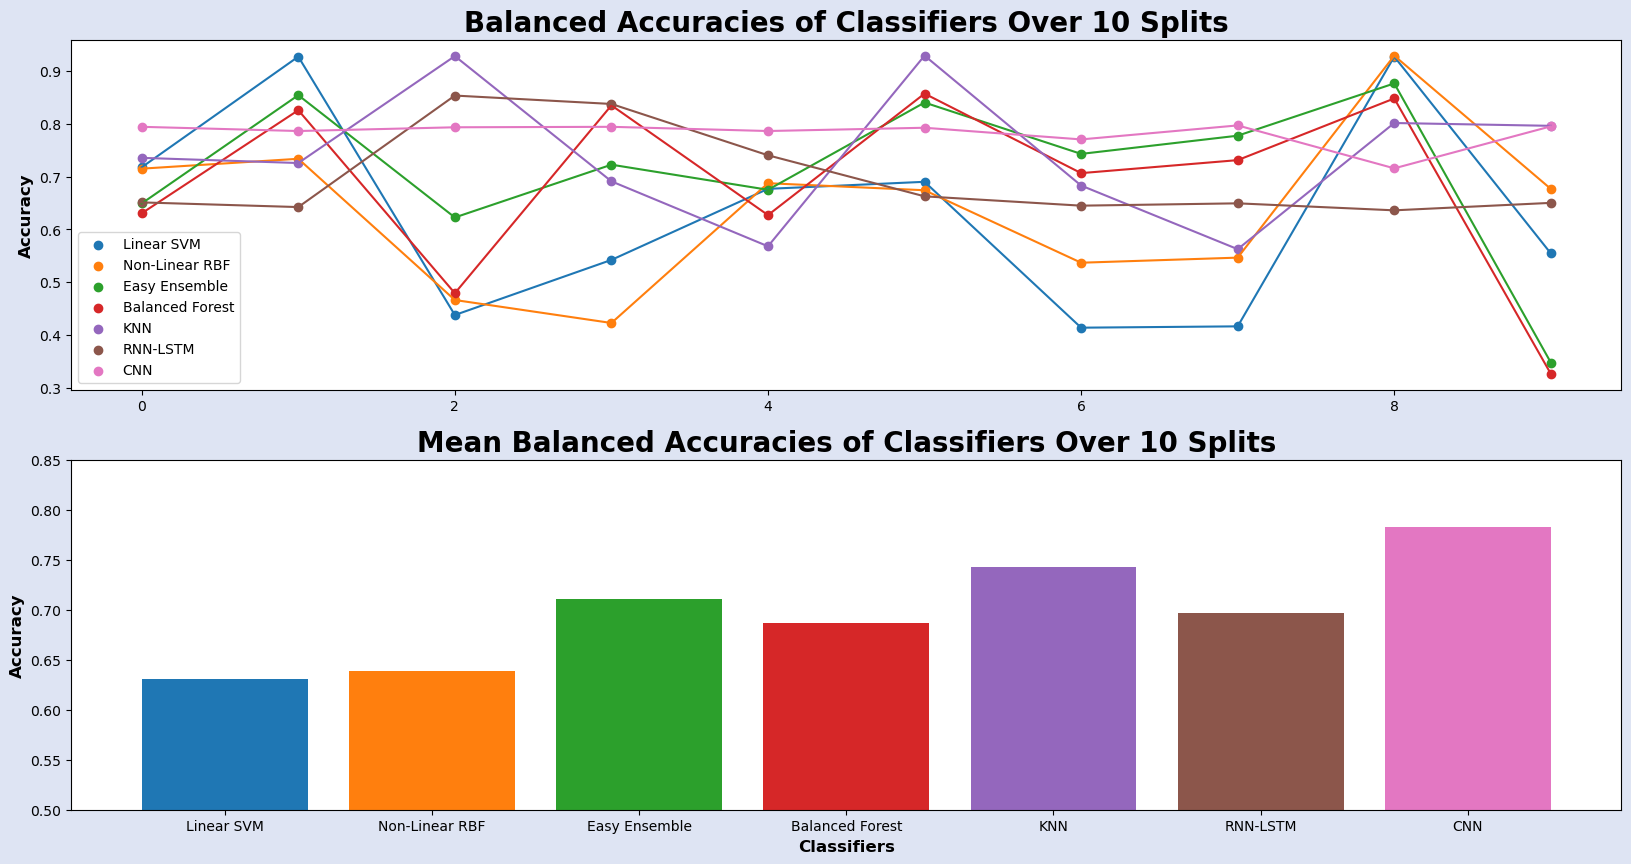

In [35]:
rnn_dictionary = { "test_balanced_accuracy": rnn_accuracy_list[1::10] }
cnn_dictionary = { "test_balanced_accuracy": cnn_accuracy[1::10] }

accuracies = [
    accuracy_svm["test_balanced_accuracy"],
    accuracy_rbf["test_balanced_accuracy"],
    accuracy_easy_e["test_balanced_accuracy"],
    accuracy_bf["test_balanced_accuracy"],
    accuracy_k["test_balanced_accuracy"],
    rnn_dictionary["test_balanced_accuracy"],
    cnn_dictionary["test_balanced_accuracy"]
]

accuracies_mean = [
    np.mean(accuracy_svm["test_balanced_accuracy"]),
    np.mean(accuracy_rbf["test_balanced_accuracy"]),
    np.mean(accuracy_easy_e["test_balanced_accuracy"]),
    np.mean(accuracy_bf["test_balanced_accuracy"]),
    np.mean(accuracy_k["test_balanced_accuracy"]),
    np.mean(rnn_dictionary["test_balanced_accuracy"]),
    np.mean(cnn_dictionary["test_balanced_accuracy"])
]

final_balanced_plots(accuracies, accuracies_mean)

# Graph Analysis
The first of the two graphs above shows the balanced accuracies that each classifier had for each fold iteration. We chose to visualize balanced accuracy here, because it is one of the most important scoring metrics for our dataset. A classifier that is deemed as useful must not only perform well when averaging out every fold iteration, but it must also be consistant in its good results. In this chart CNN can be seen as the most consistant by far with only slight changes here and there. On the other hand the linear SVC can be seen as very sparatic and all over the place on this graph.

---
The second of the graphs is a bar chart containing the average balanced accuracy accross all folds for each classifier. In this representation it is easy to see which classifiers are performing better in the area of balanced accuracy. Again it is shown here that the linear SVM performs the worst and the convolution neural network is performing the best.

# Conclusion
Our search for an appropriate exoplanet classifier was a journey of learning and discovery. Exploring and implementing methods such as PCA, SMOTE, unersampling, standardization, and normalization in processing the exoplanet dataset lead to the realization that there really is no one solution for a problem in machine learning. While some classifiers reacted well to these processing steps, others started performing worse. We are sure that if used on a different dataset these techniques would have a different result. Also sometimes preconceived assumptions about what will work well can be very wrong, so it is beneficial to keep an open mind. The biggest challenges with our dataset were how unbalanced it was, and that the features were a function of time. It was these challenges that eventually lead us to experiment with neural networks. This came after the non-linear SVM classifier only gave a slight boost to performance, and the ensemble classifiers were only slightly better than the non-linear SVM. The k-nearest neighbor was the biggest surprise. It ended up performing as well as one of the neural networks. Even with that being the case, we still feel that with a little tweaking, both the recurrent and convolution neural networks could still performed better. With great results already, we decided to end the experiments on them and conclude that for the exoplanet dataset, neural networks (and in particular the cnn) are the best classifiers for the job. The convolution neural network outdid our benchmark classifier in every metric. The reason the neural networks performed so well, was because of an earlier stated problem: the features of our dataset are a function of time. Neural networks show great promise when faced with a problem that requires pattern recognition such as finding patterns in light readings over time. We would like to conclude by proposing the use of neural networks in any time based feature set problem, even in cases of imbalance, as a standard option.

# Allocation of work
Throughout this notebook we took a colaborative style where each of our focuses would sometimes be on different aspects of the notebook, but we were always bouncing ideas back and forth as we went. For example, Lucas wrote more of the code for the neural network analysis and Brett wrote more of the StratAnalyze method, but while completing these sections an open dialogue was there in order to get the best results. The other helper methods we used for analyzing our data were very much a work in progress from the beginning to the end. We both had our hands in various iterations of the methods. The plots used in our project were also an equal collaboration. The code for the plot, where we wanted the plots, what kind of plots to use, and more, were done by both of us. The discussions throughout the project were also shared by both. Often one of us would start a template or outline (code and discussions) and the other would follow it up with finishing or editing the work. Because so much experimentation went into this project, we found that this was the best method of colaboration for the both of us, and it turned out results that we both feel proud of.

# References


### Course Github notebooks
- https://github.com/asabenhur/CS345/blob/master/fall23/notebooks/module07_01_neural_networks_mlp.ipynb
- https://github.com/asabenhur/CS345/blob/master/fall23/notebooks/module07_02_neural_networks_keras.ipynb
- https://github.com/asabenhur/CS345/blob/master/fall23/notebooks/module05_02_cross_validation.ipynb
- https://github.com/asabenhur/CS345/blob/master/fall23/notebooks/module02_03_pca.ipynb

---
### Keras documentation
- https://keras.io/api/layers/recurrent_layers/lstm/

---
### Imbalanced learn
- https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
- https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.EasyEnsembleClassifier.html
- https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

---
### Numpy
- https://numpy.org/doc/stable/reference/generated/numpy.ravel.html

---
### Scikit-learn
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
- https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

---
### TensorFlow
- https://www.tensorflow.org/tutorials/images/cnn

---
### Other Articles
- https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
- https://www.ibm.com/topics/recurrent-neural-networks

---